In [1]:
import tensorflow
from deepface import DeepFace
from IPython.display import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score
from retinaface import RetinaFace
import os
from IPython.display import Markdown, display

## Initialise helper functions

In [2]:
# Helper functions
def printmd(string):
    '''Print strings with markdown formatting parsed'''
    display(Markdown(string))
    
# Image(filename="images/dark-face/image/1.png") 
# result = cv2.imread("images/dark-face/image/1.png")
def get_bounding_boxes(image_path, bounding_boxes_path=None, bounding_boxes=[]):
    '''Shows the image with the respective bounding rectangles drawn on it'''
    
    if bounding_boxes_path:
        with open(bounding_boxes_path) as f:

            n = int(f.readline())
            while n > 0:
                n -= 1
                current_bounds = [[int(el) for el in f.readline().split()]]            
                bounding_boxes += current_bounds
                
    result = cv2.imread(image_path)
        
    
    colour = (255, 0, 0)
    thickness = 3
    i = 0
    for cntr in bounding_boxes:
        x1,y1,x2,y2 = cntr
        cv2.rectangle(result, (x1, y1), (x2, y2), colour, thickness)
        i += 1

    plt.imshow(result)
    
def evaluate_model(y_pred_filepath, y_true_filepath, n=6000):
    '''Returns
    1. % of all faces correctly recognised
    2. Average # of faces detected per image
    '''
    correct_total, correct_total_benchmark = 0, 0
    with open(y_true_filepath, "r") as f: 
        for _ in range(n):
            correct_total += int(f.readline())

    with open(y_pred_filepath, "r") as f_benchmark:
        for _ in range(n):
            correct_total_benchmark +=  int(f_benchmark.readline())
        
        prop_correct = correct_total_benchmark / correct_total * 100
        
        
    # n = total number of images
    simple_average = correct_total_benchmark / n
    printmd(f'''
% of all faces correctly recognised: **{round(prop_correct, 2)}**%\n
Average number of faces detected / image: **{round(simple_average, 2)}** / image
''')
    
def calc_f1_score(y_true_filepath, y_pred_filepath):
    '''Calculates and returns y_true (list of correct labels), y_pred (list of predicted labels), f1 score
    
    More information on the implementation of f1 score can be found here: 
    https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
    '''
    y_true = []
    y_pred = []

    with open(y_true_filepath, "r") as test_file:
        y_true = test_file.read().split()

    # to prevent unintended overwrites, the predictions computed by the model earlier are stored in another file
    with open(y_pred_filepath, "r") as pred_file:
        y_pred = pred_file.read().split()

    return y_true, y_pred, f1_score(y_true[2097:], y_pred[2097:], average='macro')

def calc_prop_wrong_per_race(y_true, y_pred):
    '''Calculates the proportion of wrongly classified faces for each race'''
    correct = 0
    wrong = 0
    correctly_classified_races = dict()
    wrongly_classified_races = {
        "0": 0,
        "1": 0,
        "2": 0,
        "3": 0,
        "4": 0
    }

    for i in range(2097, len(y_true)):
        if y_true[i] == y_pred[i]:
            correct += 1
            correctly_classified_races[y_true[i]] = correctly_classified_races.get(y_true[i], 0) + 1
        else:
            wrongly_classified_races[y_true[i]] += 1
            wrong += 1

    proportion_wrong = dict()
    for key, value in wrongly_classified_races.items():
        race = race_dict[key]
        proportion_wrong[race] = round((wrongly_classified_races[key] / (correctly_classified_races.get(key, 0) + wrongly_classified_races[key])) * 100, 2)

    for race, value in proportion_wrong.items():
        print(f"RetinaFace model classified {value}% of {race}s wrongly")

## Initialise ALL global variables

In [3]:
y_true_filepath = "results/num_test.txt"
y_pred_benchmark_filepath = "results/num_pred.txt"
y_pred_filepath = "results/num_pred_enhanced.txt"
image_directory_unprocessed = "images/dark-face/image"
image_directory_processed = "LLFlow/results/LOL_smallNet/dark_faces_small"
labels_directory_processed = "LLFlow/results/LOL_smallNet/labels"
y_true_race = "results/race_test_cases.txt"
y_pred_benchmark_race = "results/race_pred_benchmark.txt"
race_image_directory = "images/UTKFace/part1"

race_dict = {
    "0": "White",
    "1": "Black",
    "2": "Asian",
    "3": "Indian",
    "4": "Other",
    "white": "0",
    "black": "1",
    "asian": "2",
    "indian": "3"
}

# Part 1
## Preliminary research on the ethical implications of current AI

We conducted primary research by verifying that the latest state-of-the-art AI classifiers do indeed continue to perform worse in categorising Blacks.

### Store ground truths
We store the correctly labelled race, for each image, in the [UTKFace](https://susanqq.github.io/UTKFace/) dataset into a .txt file.

In [4]:
# Store ground truths into a file known as test.txt

with open(y_true_race, "w") as new_f:
    for filename in os.listdir(race_image_directory):
        f = os.path.join(race_image_directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            try:
                age, gender, race, datetime = filename.split("_")
                new_f.write(f"{race}\n")
            except Exception as e:
                print(f"Error for {i}: {e}")

### Store predicted values
These values are predicted based off a state-of-the-art deep learning facial recognition system called [RetinaFace](https://github.com/serengil/retinaface).

The implementation has been commented out as it takes ~4h for it to predict 10107 images.

In [5]:
# # Store predicted values into a file known as y_pred_benchmark_race.txt
# with open(y_pred_benchmark_race, "w") as new_f:
#     for filename in os.listdir(race_image_directory):
#         f = os.path.join(race_image_directory, filename)    
#         # checking if it is a file
#         if os.path.isfile(f):
#             try:
#                 obj = DeepFace.analyze(f, actions=['race'], detector_backend="retinaface")
#                 pred_race = obj["dominant_race"]
#                 age, gender, race, datetime = filename.split("_")
#                 # get matching digit based on predicted race. 
#                 # If predicted race does not match anything in dictionary, label as 4 (Others)
#                 new_f.write(f"{race_dict.get(pred_race.lower(), '4')}\n")
#             except Exception as e: 
#                 # failed to detect a face, store "-1"
#                 new_f.write("-1\n")
#                 print(e)
                

### Calculate baseline accuracy
We computed the f1-score for this model to obtain a benchmark for how the state-of-the-art models are currently performing in classifying different ethnicities.

In [6]:
y_true, y_pred, f1 = calc_f1_score(y_true_race, "results/race_pred_benchmark_final.txt")

printmd(f"F1 score: **{f1}**")

F1 score: **0.40617110399140416**

### Check biasness of classifier
To determine the biasness of the classifier, we computed the proportion of wrongly classified images for each race.

In [7]:
calc_prop_wrong_per_race(y_true, y_pred)

RetinaFace model classified 25.74% of Whites wrongly
RetinaFace model classified 39.53% of Blacks wrongly
RetinaFace model classified 8.74% of Asians wrongly
RetinaFace model classified 100.0% of Indians wrongly
RetinaFace model classified 61.58% of Others wrongly


## Part 2

Having verified that the current models are still indeed misclassifying Blacks more than Whites, we moved on to focusing on improving facial recognition systems for images under low light.

## Store ground truth / test cases

The following function retrieves the correct number of faces present in each image, as depicted by the "*{i}.txt*" file, where i = 1...6000.

The first n lines represent the number of faces in the ith picture where i=1...n, n = 6000.
Specifically, the 1st line has **11** faces in the picture labelled "**1.png**"

Finally, the very last line represents the total number of faces in all pictures.

The implementation has been commented out to prevent existing local files from being mistakenly updated.

In [8]:
total = 0

with open(y_true_filepath, "r+") as new_f:
    image_directory_unprocessed = "images/dark-face/label"
    for i in range(1, 6001):
        filename = f"{i}.txt"
        f = os.path.join(image_directory_unprocessed, filename)
        with open(f, "r") as label:
            try:
                num_faces = int(label.readline())
            except Exception as e:
                num_faces = 0
            total += num_faces
            new_f.write(f"{num_faces}\n")
    line = f"{total}"
    new_f.write(f"{total}\n")

## Store predicted values - Benchmark
These values are predicted based off a state-of-the-art deep learning facial recognition system called [RetinaFace](https://github.com/serengil/retinaface).

Note: **RetinaFace takes a long time to run**. Extracting the number of faces for 6000 images takes approximately 4h. As a result, the implementation has been commented out.

In [9]:
# total = 0

# for i in range(1, 6001):
#     with open(y_pred_benchmark_filepath, "a") as new_f:
#         try:
#             filename = f"{i}.png"
#             f = os.path.join(image_directory_unprocessed, filename)
#             faces = RetinaFace.extract_faces(f)
#             num_faces = len(faces)
#             total += num_faces
#             new_f.write(f"{num_faces}\n")
#             print(f"Image {i}: {num_faces} faces detected")
#         except Exception as e:
#             print(f"Error for {i}: {e}")
    
# with open(y_pred_benchmark_filepath, "a") as new_f:
#     line = f"{total}"
#     new_f.write(f"{total}\n")

## Store predicted values - Using enhanced images
These values are predicted based off a state-of-the-art deep learning facial recognition system called [RetinaFace](https://github.com/serengil/retinaface).

Note: **RetinaFace takes a long time to run**. Extracting the number of faces for 6000 images takes approximately 4h. As a result, the implementation has been commented out.

In [10]:
# total = 0

# for i in range(1, 6001):
#     with open(y_pred_filepath, "a") as new_f:
#         try:
#             f_label_path = os.path.join(labels_directory_processed, f"{i}.txt")
#             # if label file path already exists, do not write to it again
#             if os.path.isfile(f_label_path):
#                 print(f"skipping label text file for {i}")
#                 continue
#             filename = f"{i}.png"
#             f = os.path.join(image_directory_processed, filename)
#             faces = RetinaFace.detect_faces(f)
#             j = 1
#             bounded_areas = []
#             while f"face_{j}" in faces:
#                 key = f"face_{j}"
#                 j += 1
#                 bounded_areas += [faces[key]["facial_area"]]
            
#             with open(f_label_path, "a") as f_label:
#                 f_label.write(f"{len(bounded_areas)}\n")
#                 for el in bounded_areas:
#                     # convert int to string
#                     # join ls of strings by " "
#                     el_formatted = " ".join([str(el_int) for el_int in el])
#                     f_label.write(f"{el_formatted}\n")

#             num_faces = len(faces)
#             total += num_faces
#             new_f.write(f"{num_faces}\n")
#             print(f"Image {i}: {num_faces} faces detected")
#         except Exception as e:
#             print(f"Error for {i}: {e}")
    
# with open(y_pred_filepath, "a") as new_f:
#     line = f"{total}"
#     new_f.write(f"{total}\n")

## Calculate performance
Next, we calculated the performance of both the benchmark classifier (with regular images), and the classifier with enhanced images and the  through 2 simple metrics
1. % of all faces correctly recognised
2. Average # of faces detected per image

### Performance for classifier BEFORE image processing

In [11]:
evaluate_model(y_pred_benchmark_filepath, y_true_filepath, n=2100)


% of all faces correctly recognised: **13.64**%

Average number of faces detected / image: **1.13** / image


### Performance for classifier AFTER image processing

In [12]:
evaluate_model(y_pred_filepath, y_true_filepath, n=2100)


% of all faces correctly recognised: **60.05**%

Average number of faces detected / image: **4.99** / image


## Evaluate results

The results show ~**4** times increase in accuracy by the latest facial recognition system, RetinaFace. Hence, there is significant evidence to suggest that enhancing the image using the [LLFlow](https://github.com/wyf0912/LLFlow) model does indeed improve facial recognition models for images with low lighting.

## Visualise results

The following code proves that the visually enhanced images are definitively able to improve the facial recognition software, and that the facial recognition software is not simply displaying a higher false positive rate (wrongly classifying other objects as faces).

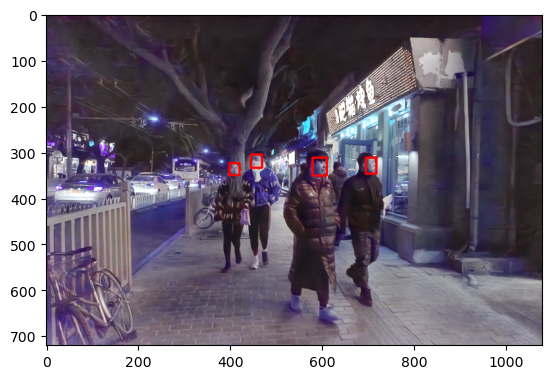

In [13]:
get_bounding_boxes(image_path="examples/enhanced/4.png", bounding_boxes_path="examples/enhanced/labels/4.txt")


## Original image

For comparison's sake, the original image is shown below. Using the original image, the RetinaFace model is unable to recognise any faces

Number of faces detected: **0**

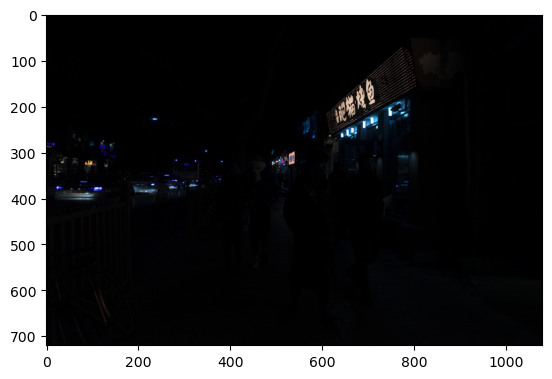

In [14]:
filepath = "examples/original/4.png"
res = cv2.imread(filepath)
plt.imshow(res)

faces = RetinaFace.extract_faces(filepath)
printmd(f"Number of faces detected: **{len(faces)}**")